In [431]:
import numpy as np
import csv
import re
from gensim.models import FastText
import string
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer

np.random.seed(0)

stops = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()
tokenizer = TreebankWordTokenizer()


def decontracted(text):
    """
    Expand common contractions in a text.
    """
    # specific
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"ain\'t", "are not", text)
    text = re.sub(r"shan\'t", "shall not", text)
    text = re.sub(r"ma\'am", "maam", text)
    text = re.sub(r"y\'all", "you all", text)

    # general
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text


def remove_urls(text):
    """
    Remove all URLs from the text and replace them with 'URL'.
    This function detects URLs starting with http, https, ftp, or www.
    """
    # Pattern to detect URLs that start with http, https, ftp, www
    url_pattern = r"(https?:\/\/|ftp:\/\/|www\.)?([-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*))"
    return re.sub(url_pattern, "URL", text)


def clean_quotes(text):
    """
    Remove &quot
    """
    return re.sub("&quot", '"', text)


def translate_emojis(text):
    """
    Translates common text-based emojis like :) or :-D to the word 'emoji'.
    """
    # Define a regex pattern to match various text-based emojis
    emoji_pattern = r"(:-\)|:\)|:-\(|:\(|:-D|:D|:-P|:P|:o|:O|<3|;\)|;-\))"

    # Replace matching emojis with the word 'emoji'
    return re.sub(emoji_pattern, " emoji ", text)


def remove_punctuations(text):
    """
    Remove punctuations.
    """
    translator = str.maketrans("", "", string.punctuation)
    return text.translate(translator)


def replace_numbers_with_text(text):
    """
    Replace all numbers (including ordinals like 13th) with the word 'number'.
    """
    # Pattern to match numbers (both plain numbers and ordinals)
    number_pattern = r"\d+(?:st|nd|rd|th)?\b"

    # Replace all matches with the word 'number'
    return re.sub(number_pattern, " number ", text)


def remove_bom(text):
    """
    Remove the Byte Order Mark (BOM) if it exists in the text.
    """
    return text.replace("\ufeff", "")


def remove_non_standard_characters(text):
    """
    Use a regular expression to remove non-standard characters.
    """
    cleaned_text = re.sub(r'[^\x20-\x7E]+', '', text)
    return cleaned_text


def clean(text):
    """
    Clean a text by applying all cleaning steps.
    """
    text = remove_bom(text)
    text = decontracted(text)
    text = translate_emojis(text)
    text = remove_urls(text)
    text = clean_quotes(text)
    text = replace_numbers_with_text(text)
    text = remove_punctuations(text)
    text = remove_non_standard_characters(text)
    return " ".join(text.split())


def lower_doc(doc):
    """
    Convert the input document to lowercase.
    """
    return doc.lower()


def tokenize_doc(doc):
    """
    Tokenize the input document using NLTK word_tokenize.
    """
    return tokenizer.tokenize(doc)


def lemmatize_doc(doc):
    """
    Lemmatize each token in the input document using WordNetLemmatizer.
    """
    return [lemmatizer.lemmatize(token) for token in doc]


def remove_stopwords(doc):
    """
    Remove stopwords from the input document.
    """
    return [token for token in doc if token not in stops]


def remove_digit(doc):
    """
    Remove tokens that consist entirely of digits.
    """
    return [
        token
        for token in doc
        if not (
            token.isdigit()
            or token.replace(".", "").isnumeric()
            or token.replace(",", "").isnumeric()
        )
    ]


def strip_doc(doc):
    """
    Strip leading and trailing whitespace from each token in the input document.
    """
    return [token.strip() for token in doc]


def remove_empty_strings(doc):
    """
    Remove empty strings from the list of tokens.
    """
    return [token for token in doc if token != "''"]


def preprocess(doc):
    """
    Preprocess a text by applying all preprocessing steps.
    """
    doc = lower_doc(doc)
    doc = tokenize_doc(doc)
    doc = remove_stopwords(doc)
    doc = remove_digit(doc)
    doc = lemmatize_doc(doc)
    doc = strip_doc(doc)
    doc = remove_empty_strings(doc)
    doc = [token for token in doc if len(token) > 1]
    return doc

# Loading data

In [432]:
x = []
y = []
with open(
    "dataset/youtube-comment-spam/Youtube-Spam-Dataset.csv",
    mode="r",
    encoding="utf-8-sig",
) as csvfile:
    reader = csv.reader(csvfile, delimiter=",")
    for i, row in enumerate(reader):
        if i > 0:
            raw_text = row[3]
            label = row[-1]
            x.append(raw_text)
            y.append(label)

x = np.array(x)
y = np.array(y)
y = y.astype("float")  # Change from int to float

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.10, random_state=42
)

x_train.shape, y_train.shape, x_test.shape, y_test.shape, set(y_train)

((1760,), (1760,), (196,), (196,), {0.0, 1.0})

# Cleaning and preprocessing

See the data, and check the result of cleaning and preprocessing.

In [433]:
random_idx = np.random.randint(0, x_train.shape[0], size=10)
for raw_text in x_train[random_idx]:
    print(f"Ori: {raw_text}")
    print(f"Cleaned: {clean(raw_text)}")
    print(f"Preprocessed: {preprocess(clean(raw_text))}")
    print()

Ori: Hello everyone :) I know most of you probably pass up these kind of comments, but for those who are still reading this, thanks! I don’t have any money for advertisements, no chance of getting heard, nothing... If this comes off as spam, sorry. I am a video animator, just trying to make it up into the video animation industry. Please give me the chance to prove myself to you. Please visit my channel, subscribe if you like and thumb this comment up, so everyone can see! Thank You! 
Cleaned: Hello everyone emoji I know most of you probably pass up these kind of comments but for those who are still reading this thanks I dont have any money for advertisements no chance of getting heard nothing If this comes off as spam sorry I am a video animator just trying to make it up into the video animation industry Please give me the chance to prove myself to you Please visit my channel subscribe if you like and thumb this comment up so everyone can see Thank You
Preprocessed: ['hello', 'everyon

Looks okay so we can clean and preprocess the text.

In [434]:
x_train_preprocessed = ([preprocess(clean(xi)) for xi in x_train])
x_test_preprocessed = ([preprocess(clean(xi)) for xi in x_test])

Then some text will be fully erased because they contains nothing. We have to exclude such text.

In [435]:
idx_with_zeros = [idx for idx, sublist in enumerate(x_train_preprocessed) if len(sublist) == 0]
x_train_preprocessed = [x for idx, x in enumerate(x_train_preprocessed) if idx not in idx_with_zeros]
y_train = np.array([y for idx, y in enumerate(y_train) if idx not in idx_with_zeros])

idx_with_zeros = [idx for idx, sublist in enumerate(x_test_preprocessed) if len(sublist) == 0]
x_test_preprocessed = [x for idx, x in enumerate(x_test_preprocessed) if idx not in idx_with_zeros]
y_test = np.array([y for idx, y in enumerate(y_test) if idx not in idx_with_zeros])

assert len(x_train_preprocessed) == y_train.shape[0]
assert len(x_test_preprocessed) == y_test.shape[0]
len(x_train_preprocessed), y_train.shape, len(x_test_preprocessed), y_test.shape

(1756, (1756,), 196, (196,))

# Embedding

## Fasttext

We will use fasttext to create embedding.

In [436]:
model = FastText(sentences=x_train_preprocessed, vector_size=20, epochs=100)

Let's see the embedding result.

In [437]:
model.wv["shuffling"]

array([ 2.100037  , -0.32556117,  0.8194484 ,  0.5022681 , -0.3093285 ,
        0.81594664, -0.7883917 , -0.11111141, -1.0363059 ,  0.800247  ,
        1.2432474 , -0.1782905 ,  0.04216917, -0.43907425, -0.36337426,
        0.39155284, -0.04192329, -0.7364609 ,  0.28817624, -0.3142197 ],
      dtype=float32)

It can even embed full sentences.

In [438]:
model.wv.most_similar("everyday i am shuffling")

[('verse', 0.8887656927108765),
 ('everyday', 0.873877763748169),
 ('everyone', 0.8161255121231079),
 ('every', 0.7015671133995056),
 ('everything', 0.688934326171875),
 ('shuffling', 0.6814234852790833),
 ('gaming', 0.6546387672424316),
 ('kind', 0.6524094343185425),
 ('singing', 0.6401467323303223),
 ('also', 0.631927490234375)]

Then we replace each word with its vector representation.

In [439]:
x_train_vector = [np.array([model.wv[word] for word in doc]) for doc in x_train_preprocessed]
x_test_vector = [np.array([model.wv[word] for word in doc]) for doc in x_test_preprocessed]

But then we see out input has different length (because sentences have different number of words.)

In [440]:
[x.shape for x in x_train_vector][:5], [x.shape for x in x_test_vector][:5]

([(4, 20), (11, 20), (3, 20), (3, 20), (6, 20)],
 [(2, 20), (4, 20), (3, 20), (50, 20), (4, 20)])

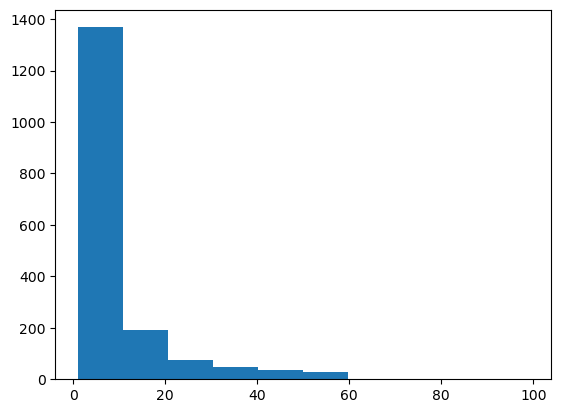

In [441]:
import matplotlib.pyplot as plt


sentence_lengths = np.array([x.shape[0] for x in x_train_vector])

plt.hist(sentence_lengths)
plt.show()

But they correctly have 2 dimensions (num_sentence, vector_size).

In [442]:
assert sum([len(x.shape) != 2 for x in x_train_vector]) == 0
assert sum([len(x.shape) != 2 for x in x_test_vector]) == 0
sum([len(x.shape) != 2 for x in x_train_vector]), sum([len(x.shape) != 2 for x in x_test_vector])

(0, 0)

Therefore we need to add padding to each sentence. I will use max_len = 10 to make the training faster and avoid vanishing gradient problem.

In [443]:
max_seq_length = 10

In [444]:
for i, _ in enumerate(x_train_vector):
    current_length = x_train_vector[i].shape[0]
    if current_length < max_seq_length:
        to_pad = max_seq_length - current_length
        padding = np.zeros((to_pad, 20))  # 20 = vector dimension
        x_train_vector[i] = np.concatenate((x_train_vector[i], padding))
    # If there are sentences longer than max_seq_length, cut
    else:
        x_train_vector[i] = x_train_vector[i][:max_seq_length]


for i, _ in enumerate(x_test_vector):
    current_length = x_test_vector[i].shape[0]
    if current_length < max_seq_length:
        to_pad = max_seq_length - current_length
        padding = np.zeros((to_pad, 20))  # 20 = vector dimension
        x_test_vector[i] = np.concatenate((x_test_vector[i], padding))
    # If there are sentences longer than max_seq_length, cut
    else:
        x_test_vector[i] = x_test_vector[i][:max_seq_length]

Now we check that everything is good.

In [445]:
x_train_vector = np.array(x_train_vector)
x_test_vector = np.array(x_test_vector)
y_train = np.array(y_train)
y_test = np.array(y_test)

print(x_train_vector.shape, x_test_vector.shape, type(x_train_vector), type(x_test_vector))
print(y_train.shape, y_test.shape, type(y_train), type(y_test))

(1756, 10, 20) (196, 10, 20) <class 'numpy.ndarray'> <class 'numpy.ndarray'>
(1756,) (196,) <class 'numpy.ndarray'> <class 'numpy.ndarray'>


## Skipped: standardization

we skip this because we do minmax scaling after this so no need.

But now we see that the values are not standardized.

In [446]:
# x_train_vector.mean(axis=(0, 1)), x_test_vector.mean(axis=(0, 1))

In [447]:
# x_train_vector.max(axis=(0, 1)), x_test_vector.max(axis=(0, 1))

We will standardize them along the embedding dimension

In [448]:
# mean = x_train_vector.mean(axis=(0, 1))  # Mean of each embedding dimension (20 dims)
# std = x_train_vector.std(axis=(0, 1))  # STD of each embedding dimension (20 dims)
# # Avoid division by zero in case std is zero for any dimension
# std[std == 0] = 1
# mean, std

In [449]:
# x_train_vector = (x_train_vector - mean) / std
# x_test_vector = (x_test_vector - mean) / std

# print(x_train_vector.mean(axis=(0, 1)).round(3), x_test_vector.mean(axis=(0, 1)).round(3))
# print()
# print(x_train_vector.std(axis=(0, 1)).round(3), x_test_vector.std(axis=(0, 1)).round(3))

## MinMax scaling

Now each embedding dimension is standardized but the range is still too big. Let's do MinMax scaling. We'll do per dimension too.

In [450]:
x_train_vector.max(axis=(0, 1)), x_train_vector.min(axis=(0, 1))

(array([5.00327587, 6.1762681 , 5.60296392, 4.4377346 , 3.59969211,
        5.5957098 , 4.13127899, 6.02035379, 5.25766945, 2.74045086,
        9.47756767, 5.16804314, 4.64546633, 2.61633706, 5.92189789,
        3.23530293, 4.87601566, 4.56241798, 4.42082071, 6.06893301]),
 array([-4.42089939, -4.34508228, -2.02596092, -2.57133055, -3.58583617,
        -3.53691268, -6.62822676, -4.02684927, -3.2152977 , -9.39277554,
        -4.49622059, -3.47398663, -4.59374619, -4.97825241, -3.67652035,
        -4.40869284, -6.15673208, -4.65572691, -3.78634834, -3.414891  ]))

In [451]:
for dim in range(x_train_vector.shape[2]):  # Iterate per dim
    min_val = x_train_vector[:, :, dim].min()
    max_val = x_train_vector[:, :, dim].max()
    # for training data
    scaled = (x_train_vector[:, :, dim] - min_val) / (max_val - min_val)
    x_train_vector[:, :, dim] = scaled
    # for test data
    scaled = (x_test_vector[:, :, dim] - min_val) / (max_val - min_val)
    x_test_vector[:, :, dim] = scaled

Check the result:

In [452]:
x_train_vector.max(axis=(0, 1)), x_train_vector.min(axis=(0, 1))

(array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]))

In [453]:
x_test_vector.max(axis=(0, 1)), x_test_vector.min(axis=(0, 1))

(array([0.8898302 , 1.        , 1.        , 1.        , 1.        ,
        0.93582054, 1.        , 0.88356315, 1.        , 1.        ,
        1.        , 1.        , 0.91588598, 1.        , 1.        ,
        1.        , 1.        , 0.92449699, 0.96660466, 0.83498649]),
 array([0.        , 0.        , 0.        , 0.        , 0.04886123,
        0.        , 0.        , 0.13224873, 0.        , 0.35440212,
        0.        , 0.05125452, 0.07828695, 0.        , 0.        ,
        0.        , 0.18119976, 0.        , 0.        , 0.01856715]))

# Dataloader

In [454]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [455]:
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, index):
        return (
            self.texts[index].astype("float32"), 
            self.labels[index].reshape(-1).astype("float32")
        )

train_dataset = TextDataset(x_train_vector, y_train)
test_dataset = TextDataset(x_test_vector, y_test)
batch_size = 4
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

for batch_idx, (inputs, targets) in enumerate(train_dataloader):
    print(f"Batch {batch_idx + 1}")
    print(f"Inputs shape: {inputs.shape}")  # Should be (batch_size, sequence_length, embedding_dim)
    print(f"Targets shape: {targets.shape}")  # Should be (batch_size, 1)
    print("Inputs:", inputs)
    print("Targets:", targets)
    break

Batch 1
Inputs shape: torch.Size([4, 10, 20])
Targets shape: torch.Size([4, 1])
Inputs: tensor([[[0.5887, 0.4231, 0.3735, 0.4818, 0.5009, 0.4565, 0.6538, 0.4783,
          0.5024, 0.6981, 0.1539, 0.3498, 0.6011, 0.5022, 0.3830, 0.7214,
          0.6707, 0.6246, 0.5275, 0.4659],
         [0.4255, 0.4267, 0.3357, 0.4355, 0.6235, 0.5240, 0.6701, 0.4528,
          0.5019, 0.7999, 0.2763, 0.5106, 0.5011, 0.6675, 0.2743, 0.6329,
          0.6562, 0.6090, 0.5768, 0.4605],
         [0.6044, 0.5027, 0.3103, 0.2376, 0.4996, 0.3246, 0.7558, 0.3520,
          0.4525, 0.7173, 0.3085, 0.4485, 0.5329, 0.7693, 0.3273, 0.6127,
          0.5482, 0.5464, 0.5130, 0.3554],
         [0.4451, 0.4206, 0.3302, 0.3548, 0.4022, 0.6297, 0.6599, 0.4312,
          0.4705, 0.6410, 0.2713, 0.4535, 0.3883, 0.6828, 0.3365, 0.5248,
          0.6440, 0.6097, 0.5415, 0.5420],
         [0.4691, 0.4130, 0.2656, 0.3669, 0.4990, 0.3873, 0.6160, 0.4008,
          0.3795, 0.7741, 0.3218, 0.4020, 0.4972, 0.6555, 0.3830, 0.5768,


# Model

In [456]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_stacked_layers,
            batch_first=True,
        )
        self.linear = nn.Linear(in_features=hidden_size, out_features=1)

    def forward(self, xs):
        batch_size = xs.shape[0]
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size)
        output, hidden = self.lstm(xs, (h0, c0))
        output = self.linear(output[:, -1, :])
        output = torch.sigmoid(output)
        return output


lstm = LSTM(input_size=20, hidden_size=64, num_stacked_layers=2)

# test if our model is working
with torch.no_grad():
    print(lstm(inputs), lstm(inputs).shape)

tensor([[0.4964],
        [0.4963],
        [0.4965],
        [0.4964]]) torch.Size([4, 1])


In [457]:
criterion = nn.BCELoss()
loss = criterion(lstm(inputs), targets)
loss

tensor(0.6931, grad_fn=<BinaryCrossEntropyBackward0>)

Let's calculate loss manually to make sure the loss calculation is correct.

In [458]:
preds = lstm(inputs).detach().numpy()
targets = targets.numpy() 
preds, targets

(array([[0.49644613],
        [0.4963268 ],
        [0.49645922],
        [0.49641505]], dtype=float32),
 array([[1.],
        [0.],
        [1.],
        [0.]], dtype=float32))

In [459]:
def bceloss(preds, targets, epsilon=1e-12):
    """
    Compute Binary Cross-Entropy (BCE) loss between predictions and targets.
    """
    # Clip predictions to avoid log(0) error
    preds = np.clip(preds, epsilon, 1 - epsilon)
    # Compute the binary cross-entropy loss
    loss = -np.sum(targets * np.log(preds) + (1 - targets) * np.log(1 - preds)) / len(
        targets
    )

    return loss.round(4)


assert(bceloss(preds, targets).round(4) == round(loss.item(), 4))
bceloss(preds, targets)

0.6931

This looks correct.

# Training

In [460]:
lr = 0.0001
optimizer = optim.Adam(lstm.parameters(), lr=lr)
epochs = 10
print_step = 1


def calculate_accuracy(outputs, targets):
    predicted = (outputs >= 0.5).float()
    correct = (predicted == targets).sum().item()  # Count correct predictions
    return correct / len(targets)  # Return accuracy as a fraction


def train_one_epoch():
    lstm.train()
    running_loss = 0.0
    running_accuracy = 0.0
    for batch_idx, (xs, ys) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = lstm(xs)
        loss = criterion(outputs, ys)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        accuracy = calculate_accuracy(outputs, ys)
        running_accuracy += accuracy
    return running_loss / (batch_idx + 1), running_accuracy / (batch_idx + 1)


def val_one_epoch():
    lstm.eval()
    running_loss = 0.0
    running_accuracy = 0.0
    with torch.no_grad():
        for batch_idx, (xs, ys) in enumerate(test_dataloader):
            outputs = lstm(xs)
            loss = criterion(outputs, ys)
            running_loss += loss.item()
            accuracy = calculate_accuracy(outputs, ys)
            running_accuracy += accuracy
    return running_loss / (batch_idx + 1), running_accuracy / (batch_idx + 1)


train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    # Training step
    train_loss, train_accuracy = train_one_epoch()
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation step
    test_loss, test_accuracy = val_one_epoch()
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    # Print training and validation loss and accuracy
    if (epoch + 1) % print_step == 0:
        print(
            f"Epoch [{epoch + 1}/{epochs}], "
            f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
            f"Validation Loss: {test_loss:.4f}, Validation Accuracy: {test_accuracy:.4f}"
        )

Epoch [1/10], Train Loss: 0.6932, Train Accuracy: 0.4977, Validation Loss: 0.6918, Validation Accuracy: 0.6071
Epoch [2/10], Train Loss: 0.6899, Train Accuracy: 0.5461, Validation Loss: 0.6887, Validation Accuracy: 0.4388
Epoch [3/10], Train Loss: 0.4674, Train Accuracy: 0.7921, Validation Loss: 0.4635, Validation Accuracy: 0.7857
Epoch [4/10], Train Loss: 0.3754, Train Accuracy: 0.8502, Validation Loss: 0.4755, Validation Accuracy: 0.7908
Epoch [5/10], Train Loss: 0.3689, Train Accuracy: 0.8554, Validation Loss: 0.4788, Validation Accuracy: 0.7908
Epoch [6/10], Train Loss: 0.3651, Train Accuracy: 0.8582, Validation Loss: 0.4780, Validation Accuracy: 0.7959
Epoch [7/10], Train Loss: 0.3620, Train Accuracy: 0.8593, Validation Loss: 0.4765, Validation Accuracy: 0.8010
Epoch [8/10], Train Loss: 0.3592, Train Accuracy: 0.8588, Validation Loss: 0.4745, Validation Accuracy: 0.8112
Epoch [9/10], Train Loss: 0.3567, Train Accuracy: 0.8588, Validation Loss: 0.4722, Validation Accuracy: 0.8112
E

[]

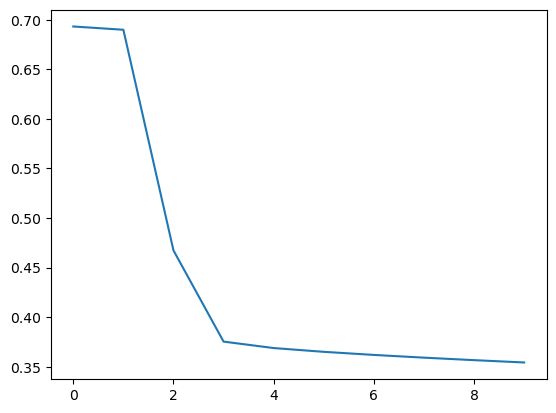

In [461]:
import matplotlib.pyplot as plt

plt.plot(range(len(train_losses)), train_losses)
plt.plot()

In [462]:
with torch.no_grad():
    for batch_idx, (xs, ys) in enumerate(train_dataloader):
        outputs = lstm(xs)
        print(outputs)
        break

tensor([[0.6924],
        [0.0748],
        [0.7370],
        [0.0913]])


We succeed in training the model!

# See prediction

In [464]:
assert x_test_vector.shape[0] == len(x_test_preprocessed)
assert len(x_test) == len(x_test_preprocessed)

# Iterate through the test data
for i, (vector, clean_text, raw_text, label) in enumerate(
    zip(x_test_vector, x_test_preprocessed, x_test, y_test)
):
    # Reshape the vector and convert to a PyTorch tensor
    vector = torch.from_numpy(vector.reshape(1, 10, 20).astype("float32"))

    # Get the model prediction
    pred = lstm(vector).detach().item()
    pred_label = (pred >= 0.5) * 1.0

    # Print the results
    print(f"Raw text: {raw_text}")
    print(f"Preprocessed text: {clean_text}")
    print(f"True vs  predicted label: {pred_label} vs {label}")
    if pred_label == label:
        print("Prediction is CORRECT.")
    else:
        print("Prediction is INCORRECT.")

    print()

    # Limit to the first 10 predictions
    if i + 1 == 10:
        break

Raw text: Charlie from LOST?﻿
Preprocessed text: ['charlie', 'lost']
True vs  predicted label: 0.0 vs 0.0
Prediction is CORRECT.

Raw text: BEST SONG EVER X3333333333﻿
Preprocessed text: ['best', 'song', 'ever', 'number']
True vs  predicted label: 0.0 vs 0.0
Prediction is CORRECT.

Raw text: Aslamu Lykum... From Pakistan﻿
Preprocessed text: ['aslamu', 'lykum', 'pakistan']
True vs  predicted label: 0.0 vs 1.0
Prediction is INCORRECT.

Raw text: I absolutely adore watching football plus I’ve started earning income with out risk from claiming bonus deals. It’s a weird technique where you put money on something with one bookmakers and put money against it on Betfair. You acquire the bonus as income . A lad named Jim Vanstone is selecting the wagers free on his website Vanstone Secrets (Google it!). I have generated about 600 quid so far. And it’s free. I assume the bookmakers pay him to get new men and women, but it succeeds.
Preprocessed text: ['absolutely', 'adore', 'watching', 'football